# Gaussian Process Regression

Numpy implementation of gaussian process regression,
reference from [krasserm](http://krasserm.github.io/2018/03/19/gaussian-processes/).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
sys.path.append("/")  # enable import of "recipe"
os.chdir("/work/")

In [3]:
from recipes.main import load_experiment
experiment = load_experiment(recipe="_2020_06_23_rewrite", 
                             experiment="test", 
                             schema="anix_nnfabrik_test",  # schema name will automatically be generated from recipe and experiment names 
                             base_dir="/recipes/",
                             import_prefix="recipes.", 
                             dev_mode=True  
                            )

Connecting anix@134.2.168.16:3306


In [66]:
from bias_transfer.gp.kernels import *
from bias_transfer.gp.utils import *
from bias_transfer.gp.gp_regression import *
from bias_transfer.gp.neural_networks import *
from bias_transfer.gp.nn_kernel import *
from bias_transfer.gp.data import *

In [188]:
X_plot, Y_plot, X_train, Y_train = load_co2()

/src/bias_transfer/bias_transfer/gp/data.py:42: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data_train = np.concatenate((f['data'].value, f['label'].value), axis=1)


## 1. Kernel definition


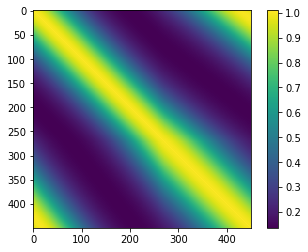

In [183]:
kernel = add_white_noise(periodic)
plot_kernel(kernel, x=X_plot)

## 2. Define prior

Zero mean, covariance from kernel

In [189]:
mu = np.zeros(X_plot.shape[0])
cov = kernel(X_plot, X_plot, sigma=0.1)

# sampling functions from multivariate normal distributio
samples = np.random.multivariate_normal(mu.reshape(-1), cov, 3)

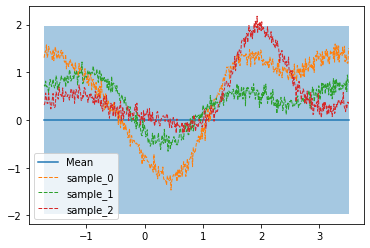

In [190]:
plot_gp(mu, cov, X_plot, samples)

## 3. Compute posterior

Compute posterior with gaussian process regression

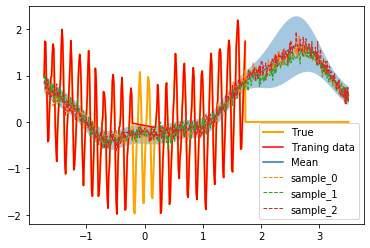

In [191]:
mu_s, cov_s = posterior_predictive(X_plot, X_train, Y_train, kernel)
samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 3)
plot_gp(mu_s, cov_s, X=X_plot, samples=samples, Y=Y_plot, X_train=X_train, Y_train=Y_train)

## 4. Optimize Hyperparameters

In [155]:
fitted_kernel = optimize_hyper_params(kernel, X_train, Y_train)
mu_s, cov_s = posterior_predictive(X_plot, X_train, Y_train, fitted_kernel)

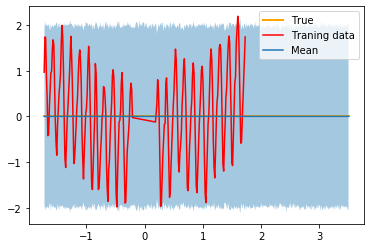

In [156]:
plot_gp(mu_s, cov_s, X=X_plot, Y=Y_plot, X_train=X_train, Y_train=Y_train)

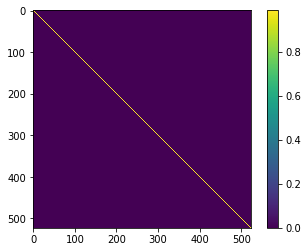

In [157]:
plot_kernel(fitted_kernel, X_plot)

## 5. Fitting a Neural Network

In [158]:
net, device = get_net(activation="relu", dropout=0.2, width=1024, layers=6) # 4 hidden layers = 6 layers
net

InvNet(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=1024, out_features=1, bias=False)
  )
)

In [159]:
trainer(net, X_train, Y_train, rdm_matching=False, device=device, epoch=50000, batch_size=1000, optim="Adam", scheduler=False)

100%|██████████| 50000/50000 [6:07:42<00:00,  2.27it/s, epoch_loss=0.0993]  


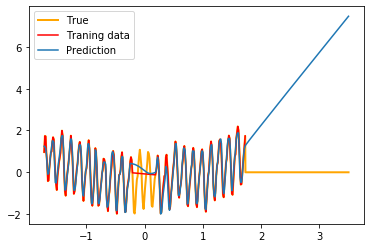

In [206]:
evaluate_net(net, X_train, Y_train, X_plot, Y_plot, device, save="nn_result.png")

## 6. Use Network as kernel and look at corresponding GP (Naive approach)

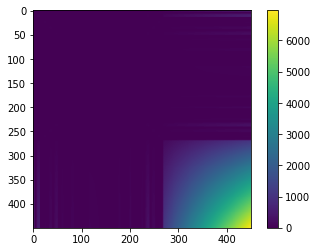

In [203]:
v = net[-1].weight.detach().cpu().numpy().T
nn_kern = partial(nn_kernel,net=net, device=device, sigma=None)
plot_kernel(nn_kern, x=X_plot)

In [204]:
Y_pred = net(
        torch.tensor(X_train, dtype=torch.float).to(device)
    ).squeeze().detach().cpu().numpy()  # input x and predict based on x

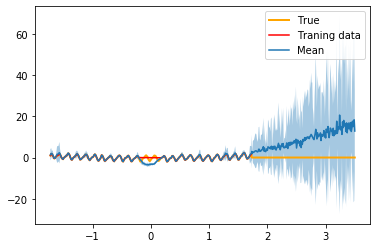

In [205]:
mu_s, cov_s = posterior_predictive(X_plot, X_train, Y_train, kernel=nn_kern)
plot_gp(mu_s, cov_s, X=X_plot, Y=Y_plot, X_train=X_train, Y_train=Y_train, save="naive_nn_gp.png")

## 7. Use Network as kernel and look at corresponding GP

In [196]:
nn_kern, base_points_pred, base_points = get_nn_eigen_kernel(net, device) 

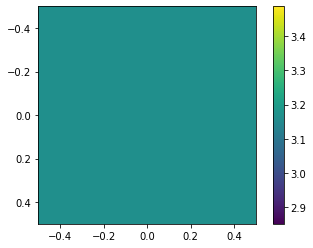

In [197]:
plot_kernel(nn_kern, x=np.zeros((len(base_points_pred),)))

 15%|█▍        | 7274/50000 [16:43:32<98:14:35,  8.28s/it, epoch_loss=0.722]


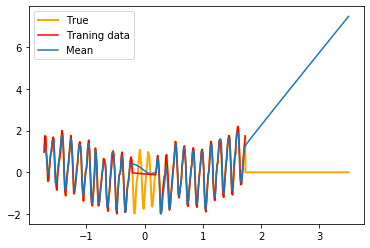

In [200]:
mu_s, cov_s = posterior_predictive(X_plot, np.zeros((len(base_points_pred),)), base_points_pred, kernel=nn_kern)
plot_gp(mu_s, cov_s, X=X_plot, Y=Y_plot, X_train=X_train, Y_train=Y_train, save="no_noise_nn_gp.png")

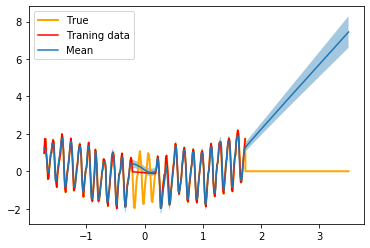

In [199]:
noise_kernel = add_white_noise(nn_kern) 
# noise_kernel = optimize_noise(noise_kernel, np.zeros((len(base_points_pred),)), base_points_pred)
mu_s, cov_s = posterior_predictive(X_plot, np.zeros((len(base_points_pred),)), base_points_pred, kernel=noise_kernel)
plot_gp(mu_s, cov_s, X=X_plot, Y=Y_plot, X_train=X_train, Y_train=Y_train, save="nn_gp.png")

<Figure size 432x288 with 0 Axes>